## Step 0 : Initialization

In [13]:
import numpy as np
import string
import re
from collections import defaultdict
import nltk
import random
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part A

### Step 1 : Processing the Data

 here we define a function that gets all of the corpus as an input and does preproceessings that are:
 first make the text lower case, second we remove all of the numbers, the we split the sentences and then we remove stopwords in all sentences and count each sentence and word for further processings on corpus.

In [14]:
# define the preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Tokenize text into sentences
    sentences = text.split(".")
    
    # Remove stopwords and punctuation from each sentence
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = []
    for i in range(len(sentences)):
        # Remove leading/trailing whitespace
        sentences[i] = sentences[i].strip()
        # Tokenize sentence into words
        sentence_words = sentences[i].split()
        # Remove stopwords and punctuation from sentence
        filtered_words = [word.strip(string.punctuation) for word in sentence_words if word not in english_stopwords]
        # Convert remaining words to lowercase
        lowercase_words = [word.lower() for word in filtered_words]
        # Add filtered sentence to list of filtered sentences
        tokens_wo_stopwords.append(lowercase_words)
        
    # Return the list of filtered sentences
    return tokens_wo_stopwords

In [15]:
# load the text data

text = open("/content/drive/MyDrive/NLP/HW2/t8.shakespeare.txt", 'rb').read().decode(encoding='utf-8')

# preprocess the text
sentences = preprocess(text)


In [16]:
# Create an empty dictionary to hold the vocabulary
vocab_dict = {}

# Iterate over each sentence in the list of sentences
for sentence in sentences:
    # Iterate over each word in the sentence
    for word in sentence:
        # Increment the count of the word in the dictionary or add it with a count of 1
        vocab_dict[word] = vocab_dict.get(word, 0) + 1

# Convert the keys of the dictionary to a list to obtain the vocabulary
vocab = list(vocab_dict.keys())

# Compute some statistics
all_tokens_size = sum(vocab_dict.values())  # Compute total number of tokens
num_sentences = len(sentences)  # Count number of sentences
vocab_size = len(vocab)  # Count vocabulary size

# Print the statistics
print("Number of sentences:", num_sentences)
print("Vocabulary size:", vocab_size)

Number of sentences: 78026
Vocabulary size: 28863


### Step 2 : skipgram model

In [17]:

def skipgram(window_size,number_negative_examples,num_sentences,vocab,sentences):
  # Create arrays to hold positive and negative examples
  positive_examples = np.zeros((len(vocab), len(vocab)))
  negative_examples = np.zeros((len(vocab), len(vocab)))  
  # Loop through each sentence in the corpus
  for sentence in sentences:
      # Loop through each word in the sentence
      for i in range(len(sentence)):
          # Get the index of the current word in the vocabulary
          word_index = vocab.index(sentence[i])

          # Loop through the words in the context window around the current word
          for j in range(i - window_size, i + window_size + 1):
              # Skip the current word itself and out-of-bounds words
              if j != i and 0 <= j < len(sentence):
                  # Get the index of the context word in the vocabulary
                  context_index = vocab.index(sentence[j])

                  # Set the corresponding entry in the positive examples array to 1
                  positive_examples[word_index, context_index] = 1

  # Loop through each word in the vocabulary
  for i in range(len(vocab)):
      # Get the indices of the words that appear in positive examples for this word
      positive_indices = np.where(positive_examples[i] == 1)[0]

      # Loop through each positive example
      for j in positive_indices:
          # Generate k negative examples
          for n in range(number_negative_examples):
              while True:
                  # Randomly select a word that is not the current word or a positive example
                  index = random.choice(range(len(vocab)))
                  if index != i and index not in positive_indices:
                      negative_examples[i, index] = 1
                      break
  return positive_examples,negative_examples



Here we call the skipgram model  use window size of 2 and k(number_negative_examples) of 4

In [18]:
# Define window size for context
window_size = 2

# Define multiplier for negative examples
number_negative_examples = 4

positive_examples,negative_examples = skipgram(window_size,number_negative_examples,num_sentences,vocab,sentences)



In [19]:
def sigmoid(x):
  return 1.0/(1.0 + np.exp(-x))

In [20]:
import numpy as np
context_vectors = np.random.random(size=(len(vocab), 100))
target_vectors = np.random.random(size=(len(vocab), 100))

In [21]:
from tqdm import tqdm

learning_rate = 0.001
epochs = 15
num_features = 100 

# Loop over epochs
for epoch in tqdm( range(epochs) ):
    
    # Loop over each word in the vocabulary
    for word_index in range(len(vocab)):
        
        # Find the indexes of positive and negative examples for the current word
        pos_indexes = np.where(positive_examples[word_index] == 1)[0]
        neg_indexes = np.where(negative_examples[word_index] == 1)[0]
        
        # Loop over each positive example
        for pos_index in pos_indexes:
            
            # Sample k negative examples at random
            neg_indices = random.choices(neg_indexes, k=number_negative_examples)
            
            # Update the context vector for the positive example
            pos_prob = sigmoid(np.dot(context_vectors[pos_index], target_vectors[word_index]))
            context_vectors[pos_index] = context_vectors[pos_index] - learning_rate * ((pos_prob - 1) * target_vectors[word_index])
            
            # Update the context vectors for the negative examples and accumulate the negative probabilities
            neg_prob_vector = np.zeros(num_features)
            for neg_index in neg_indices:
                neg_prob = sigmoid(np.dot(context_vectors[neg_index], target_vectors[word_index]))
                context_vectors[neg_index] = context_vectors[neg_index] - learning_rate * (neg_prob * target_vectors[word_index])
                neg_prob_vector = neg_prob_vector + neg_prob * context_vectors[neg_index]
            
            # Update the target vector for the current word
            target_vectors[word_index] = target_vectors[word_index] - learning_rate * ((pos_prob - 1) * context_vectors[pos_index] + neg_prob_vector)


100%|██████████| 15/15 [23:21<00:00, 93.44s/it]


Creating word_context_vectors with sum of target and context vectors

In [24]:
word_context_vectors = target_vectors + context_vectors

## Part B : PCA Transform

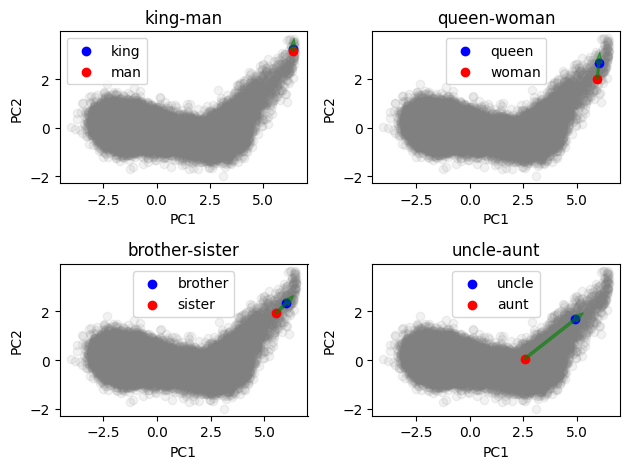

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# create a PCA object with 2 components
pca = PCA(n_components=2)

# fit the word vectors to the PCA object
word_vectors_pca = pca.fit_transform(word_context_vectors)

# create a dictionary of the four vector pairs
vector_pairs = {'king-man': ('king', 'man'), 
                'queen-woman': ('queen', 'woman'), 
                'brother-sister': ('brother', 'sister'), 
                'uncle-aunt': ('uncle', 'aunt')}

# create a plot for each vector pair
for i, (pair_name, (w1, w2)) in enumerate(vector_pairs.items()):
    # find the vector difference
    diff = word_vectors_pca[vocab.index(w1)] - word_vectors_pca[vocab.index(w2)]
    # transform the difference vector to 2D using PCA
    #diff_pca = pca.transform(diff.reshape(1, -1))
    
    # create a subplot and scatter plot the word vectors
    plt.subplot(2, 2, i+1)
    plt.scatter(word_vectors_pca[:,0], word_vectors_pca[:,1], alpha=0.1, color='gray')
    
    # plot the two words with different colors
    w1_idx, w2_idx = vocab.index(w1), vocab.index(w2)
    plt.scatter(word_vectors_pca[w1_idx,0], word_vectors_pca[w1_idx,1], color='blue', label=w1)
    plt.scatter(word_vectors_pca[w2_idx,0], word_vectors_pca[w2_idx,1], color='red', label=w2)

    # plot the vector difference
    plt.arrow(word_vectors_pca[w2_idx,0], word_vectors_pca[w2_idx,1], 
              diff[0], diff[1], color='green', width=0.1, alpha=0.5)
    
    # add labels and title
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(pair_name)
    plt.legend()

plt.tight_layout()
plt.show()
